In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image

In [2]:
#定义超参数
batch_size = 4  # 分批训练量
learning_rate = 1e-3  # 学习率
num_epoches = 10  # 训练次数
root="./big_data"

## 重写dataset，加载数据

In [3]:
class MyDataset(Dataset):
    def __init__(self, main_dir, is_train=True):
        self.dataset = [] # 列表
        data_filename = "TRAIN" if is_train else "TEST"
        # 循环获得样本数据文件夹下的训练集或测试集文件夹下的文件夹名（类别名）
        for i, cls_filename in enumerate(os.listdir(os.path.join(main_dir, data_filename))):
            # 循环获得每个类别文件夹下的数字图片
            for img_data in os.listdir(os.path.join(main_dir, data_filename, cls_filename)):
                self.dataset.append([os.path.join(main_dir, data_filename, cls_filename, img_data), i])  # i作标签

    def __len__(self):
        return len(self.dataset)  # 获取数据集长度（个数）,方便迭代

    def __getitem__(self, index):  # 里面包括迭代器
        data = self.dataset[index]  # 根据索引来取[[图片数据路径、标签]...]        [图片数据路径、标签]
        image_data = self.image_preprocess(Image.open(data[0]))  # 拿到图片数据路径并打开得到图片数据，并且做预处理。
        label_data = data[1]  # 拿到图片标签
        return image_data, label_data

    def image_preprocess(self, x):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([224,224])
        ])(x)  # 对图片数据进行预处理

train_data=MyDataset(root,True)
test_data=MyDataset(root,False)
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:

print(len(train_data))
print(len(test_data))

2819
581


## 部分数据的展示

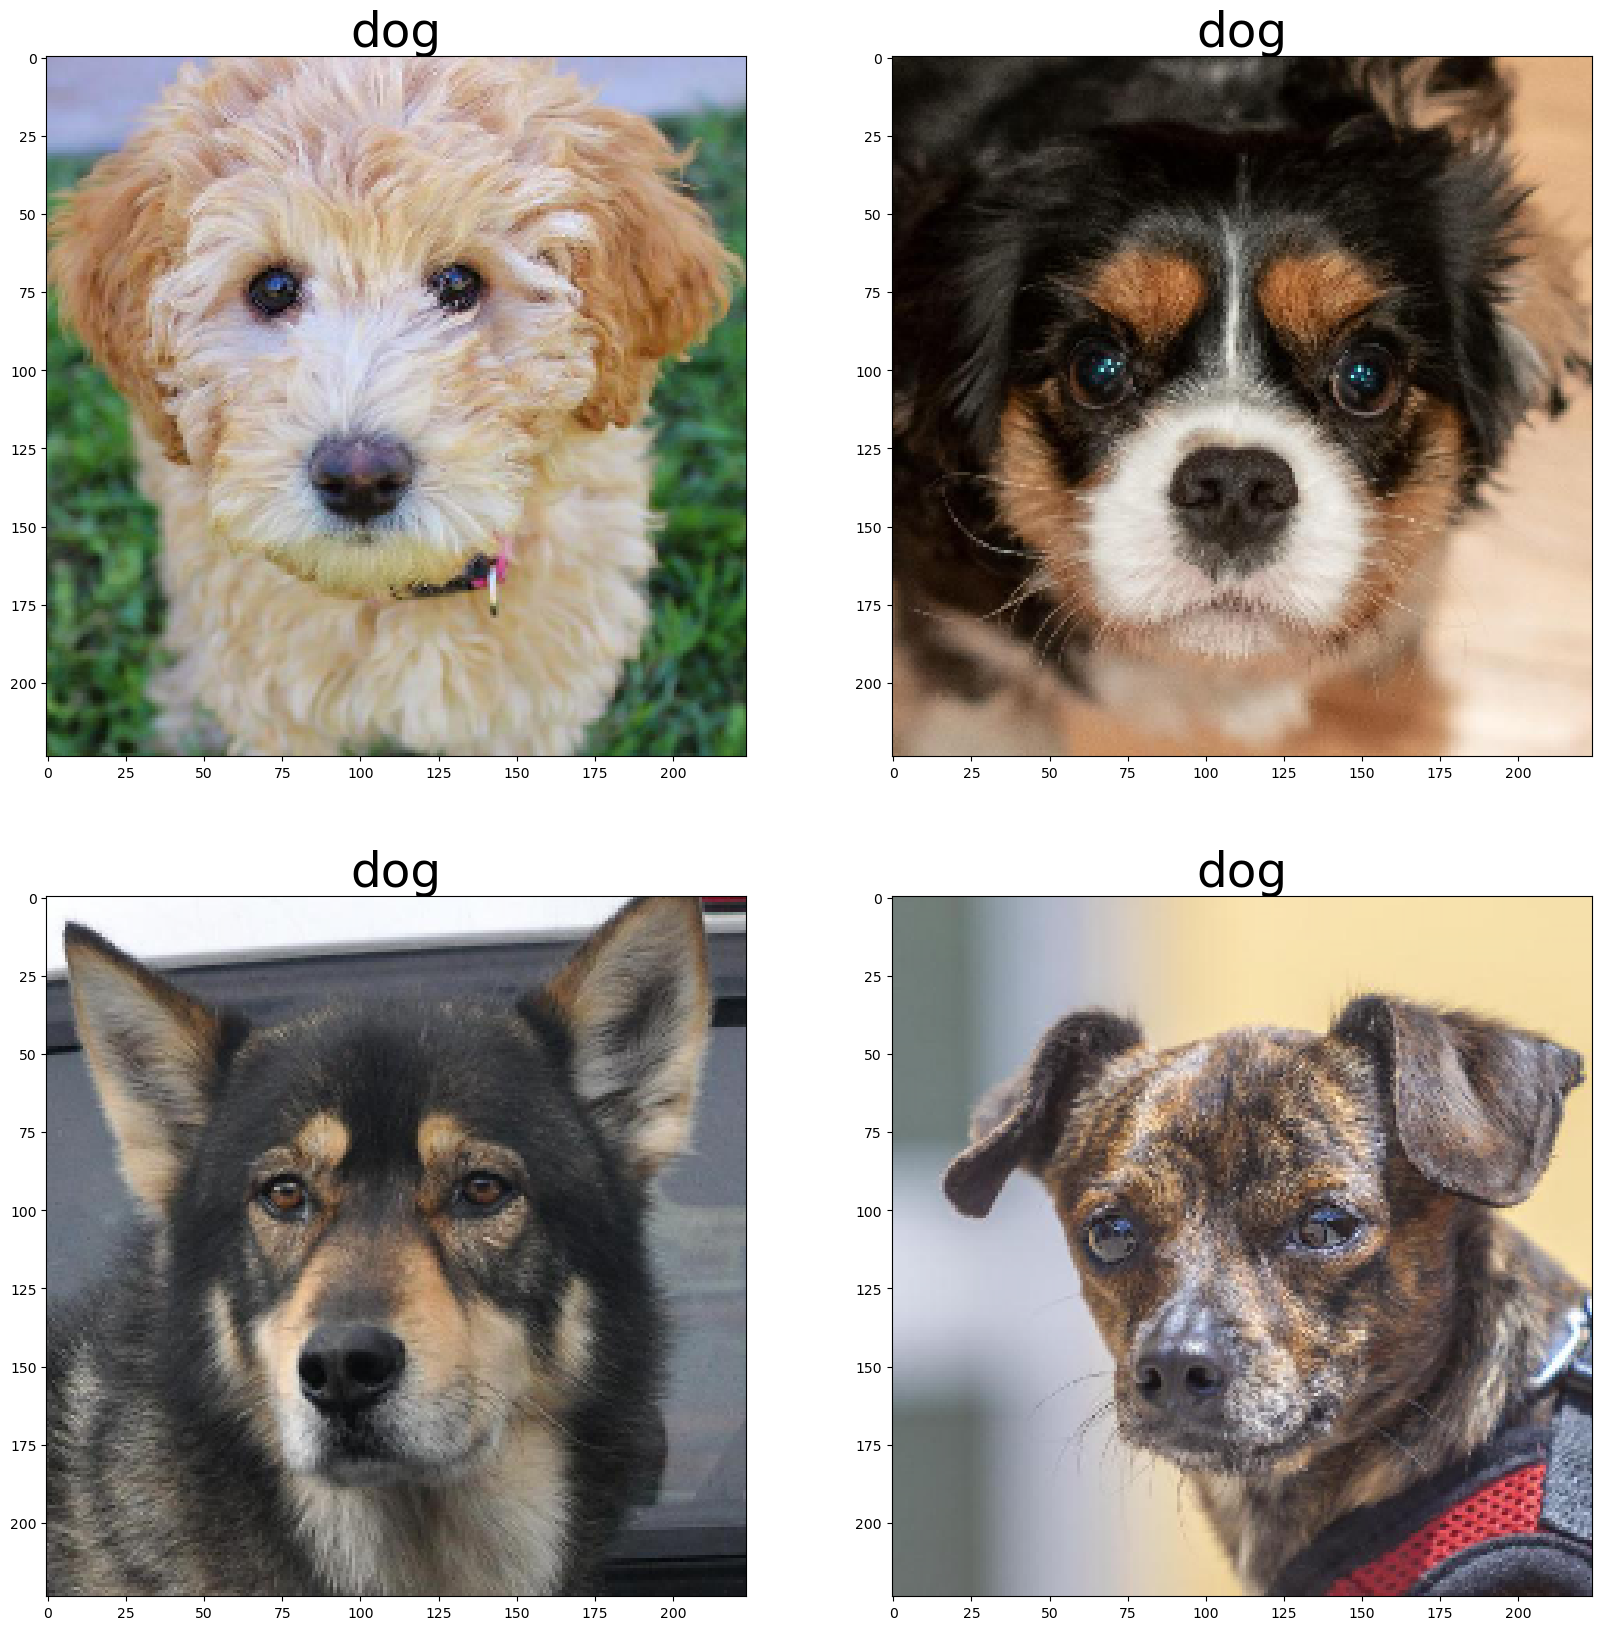

In [5]:
def im_convert(tensor):
    """ 展示数据"""
#     tensor.clone()  返回tensor的拷贝，返回的新tensor和原来的tensor具有同样的大小和数据类型
#     tensor.detach() 从计算图中脱离出来。
    image = tensor.to("cpu").clone().detach()
    
#     numpy.squeeze()这个函数的作用是去掉矩阵里维度为1的维度
    image = image.numpy().squeeze()
    
#     将npimg的数据格式由（channels,imagesize,imagesize）转化为（imagesize,imagesize,channels）,
#     进行格式的转换后方可进行显示
    image = image.transpose(1,2,0)

    #image = image * np.array((0.229,0.224, 0.225)) + np.array((0.485,0.456,0.406))
#     使用image.clip(0, 1) 将数据 限制在0和1之间
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 20))


dataiter = iter(train_loader)
inputs, classes = next(dataiter)

for idx in range (4):
    ax = fig.add_subplot(2,2,idx+1)
    if classes[idx] == 0:
        ax.set_title("cat", fontsize = 35)
    else:
        ax.set_title("dog", fontsize = 35)
    plt.imshow(im_convert(inputs[idx]))
plt.savefig('pic1.jpg', dpi=1000) #指定分辨率保存
plt.show()

## 定义模型

In [6]:
import torch.nn.functional as F

# 找到可以用于训练的 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# 定义模型
class LeNet(nn.Module):
    # 一般在__init__中定义网络需要的操作算子，比如卷积、全连接算子等等
    def __init__(self):
        super(LeNet, self).__init__()
        self.module=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.Linear(in_features=16*53*53,out_features=120),
            nn.Linear(in_features=120,out_features=84),
            nn.Linear(in_features=84,out_features=2)
        )
    # forward这个函数定义了前向传播的运算，只需要像写普通的python算数运算那样就可以了
    def forward(self, x):
        return self.module(x)

model = LeNet().to(device)
print(model)

Using cuda device
LeNet(
  (module): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=44944, out_features=120, bias=True)
    (8): Linear(in_features=120, out_features=84, bias=True)
    (9): Linear(in_features=84, out_features=2, bias=True)
  )
)


## 损失函数与优化器

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 定义训练函数

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 向前运算
        pred = model(X)
        # 计算损失
        loss = loss_fn(pred, y)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


## 定义测试函数

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 进行训练测试

In [10]:

for t in range(num_epoches):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.697821  [    0/ 2819]
loss: 0.684547  [  400/ 2819]
loss: 0.705299  [  800/ 2819]
loss: 0.637547  [ 1200/ 2819]
loss: 0.629972  [ 1600/ 2819]
loss: 0.671574  [ 2000/ 2819]
loss: 0.658505  [ 2400/ 2819]
loss: 0.603845  [ 2800/ 2819]
Test Error: 
 Accuracy: 75.6%, Avg loss: 0.651094 

Epoch 2
-------------------------------
loss: 0.629717  [    0/ 2819]
loss: 0.713893  [  400/ 2819]
loss: 0.677334  [  800/ 2819]
loss: 0.441640  [ 1200/ 2819]
loss: 0.397912  [ 1600/ 2819]
loss: 1.265224  [ 2000/ 2819]
loss: 0.578890  [ 2400/ 2819]
loss: 0.267975  [ 2800/ 2819]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.478064 

Epoch 3
-------------------------------
loss: 0.488978  [    0/ 2819]
loss: 0.292814  [  400/ 2819]
loss: 0.142669  [  800/ 2819]
loss: 0.471958  [ 1200/ 2819]
loss: 0.563068  [ 1600/ 2819]
loss: 0.383830  [ 2000/ 2819]
loss: 0.592596  [ 2400/ 2819]
loss: 0.416488  [ 2800/ 2819]
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.566778 

Epoc

## 保存和读取模型

In [11]:
#保存完整模型
torch.save(model, "model.pth")
#读取
model = torch.load("model.pth")

## 单张图片识别

image_tensor的形状:torch.Size([1, 3, 224, 224])
向前运算结果: tensor([[ 0.0959, -0.1719]], device='cuda:0', grad_fn=<AddmmBackward0>)
图像的标签为:0


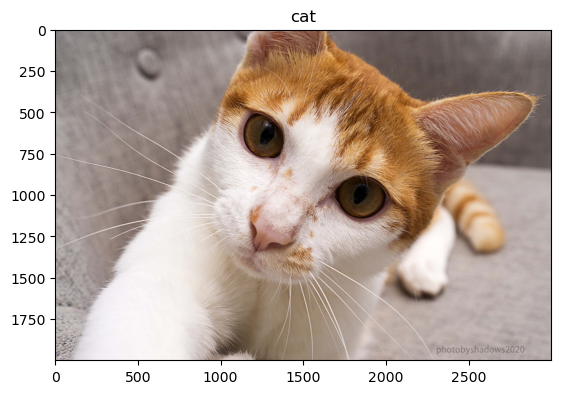

In [16]:
import torch
from PIL import Image

input_image = Image.open('./original_pic/mine/cat02.jpg')

transform_test = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_tensor = transform_test(input_image)
#增加维度，等于image_tensor=image_tensor.unsqueeze(0)
#image_tensor.unsqueeze_(0)
image_tensor=image_tensor.view(-1,3,224,224)
print("image_tensor的形状:{}".format(image_tensor.shape))
image_tensor = image_tensor.to(device)
out = model(image_tensor)
print("向前运算结果:",out)
_,pred = torch.max(out, 1)
print("图像的标签为:{}".format(pred.item()))
plt.figure()
if pred.item()==0:
    plt.title("cat")
    plt.imshow(input_image)
    plt.show()
else:
    plt.title("dog")
    plt.imshow(input_image)
    plt.show()